# Traffic Sign Classifier with TensorFlow
-  Strcuture: Modified LeNet-5
- Dataset Source:[German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

# Load The Data

In [3]:
%%capture
#import
import pickle
import cv2
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

In [4]:
# Load pickled data
import pickle

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

### Basic Summary of the Data Set

In [5]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(pd.unique(y_train))
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Index: 22430
13


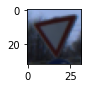

In [6]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))

plt.figure(figsize=(1,1))
plt.imshow(X_train[index], cmap="gray")
print("Index: {}".format(index))
print(y_train[index])

----

## Modified LeNet Architecture

### Pre-process the Data Set: normalization

In [7]:
x_min = X_train.min()
x_max = X_train.max()
X_train_std = (X_train - x_min)/(x_max - x_min)
X_valid_std = (X_valid - x_min)/(x_max - x_min)
X_test_std = (X_test - x_min)/(x_max - x_min)

199
0.7803921568627451


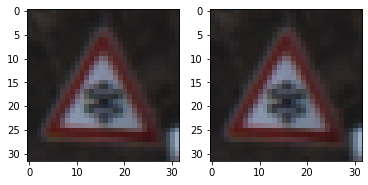

In [8]:
f, axarr = plt.subplots(1,2)
index = random.randint(0, len(X_train))
axarr[0].imshow(X_train[index])
axarr[1].imshow(X_train_std[index])
print(np.max(X_train[index]))
print(np.max(X_train_std[index]))

### Model Architecture

In [9]:
# Input variable
#Input image batch
x = tf.placeholder(tf.float32, (None, 32, 32, 3))

#Input label batch
y = tf.placeholder(tf.int32, (None))

#Encoding 
one_hot_y = tf.one_hot(y, 43)

In [10]:
#Main structure: LeNet
def LeNet(x, w_mu = 0, b_mu = 0.05, sigma = 0.05, keep_prob = 1):
    F_W = {
        "c1": tf.Variable(tf.truncated_normal([5, 5, 3, 10], mean = w_mu, stddev = sigma)),
        "c2": tf.Variable(tf.truncated_normal([5, 5, 10, 18], mean = w_mu, stddev = sigma)),
        "c3": tf.Variable(tf.truncated_normal([5, 5, 18, 26], mean = w_mu, stddev = sigma)),
        "f3": tf.Variable(tf.truncated_normal([650, 400], mean = w_mu, stddev = sigma)),
        "f4": tf.Variable(tf.truncated_normal([400, 240], mean = w_mu, stddev = sigma)),
        "out": tf.Variable(tf.truncated_normal([240, 43], mean = w_mu, stddev = sigma))
    }
    F_B = {
        "c1": tf.Variable(tf.truncated_normal([10], mean = b_mu, stddev = sigma)),
        "c2": tf.Variable(tf.truncated_normal([18], mean = b_mu, stddev = sigma)),
        "c3": tf.Variable(tf.truncated_normal([26], mean = b_mu, stddev = sigma)),
        "f3": tf.Variable(tf.truncated_normal([400], mean = b_mu, stddev = sigma)),
        "f4": tf.Variable(tf.truncated_normal([240], mean = b_mu, stddev = sigma)),
        "out": tf.Variable(tf.truncated_normal([43], mean = b_mu, stddev = sigma))
    }
    # L1: Convolutional
    padding = "VALID"
    strides = [1,1,1,1]
    l1 = tf.nn.conv2d(x, F_W["c1"], strides, padding) + F_B["c1"]
    l1_relu = tf.nn.relu(l1)

    # L1 Pooling
    strides = [1,2,2,1]
    ksize = [1,2,2,1]
    l1_p = tf.nn.max_pool(l1_relu, ksize, strides, padding)
    
    # L2: Convolutional
    strides = [1,1,1,1]
    l2 = tf.nn.conv2d(l1_p, F_W["c2"], strides, padding) + F_B["c2"]
    l2_relu = tf.nn.relu(l2)
    
    # L2 Pooling
    strides = [1,2,2,1]
    l2_p = tf.nn.max_pool(l2_relu, ksize, strides, padding)
    
    # L3: Convolutional
    strides = [1,1,1,1]
    padding = "SAME"
    l3 = tf.nn.conv2d(l2_p, F_W["c3"], strides, padding) + F_B["c3"]
    l3_relu = tf.nn.relu(l3)
    
    # Flatten
    flat = flatten(l3_relu)
    
    # L3: Fully Connected
    l4 = tf.add(tf.matmul(flat,F_W["f3"]),F_B["f3"])
    l4_relu = tf.nn.relu(l4)
    
    # L4: Fully Connected
    l5 = tf.add(tf.matmul(l4_relu,F_W["f4"]),F_B["f4"])
    l5_relu = tf.nn.relu(l5)
    l5_relu = tf.nn.dropout(l5_relu, keep_prob)
    
    # L5: Fully Connected
    logits = tf.add(tf.matmul(l5_relu,F_W["out"]),F_B["out"])
    
    return logits

### Train, Validate and Test the Model

In [11]:
%%capture
#Training pipeline
rate = 0.002
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#saver setup
saver = tf.train.Saver()

In [12]:
#Hyperparameters
EPOCHS = 14
BATCH_SIZE = 128
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
# Training
%%capture
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_std)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_std, y_train = shuffle(X_train_std, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_std[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        training_accuracy = evaluate(X_train_std,y_train)    
        validation_accuracy = evaluate(X_valid_std, y_valid)

        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    saver.save(sess, './lenet') 
    print("Model saved")

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [13]:
#Load image fetched from internet
dim = (32, 32)
img_path = {2:"./newImage/2.png",3:"./newImage/3.jpg",4:"./newImage/4.jpeg",5:"./newImage/5.jpg",6:"./newImage/6.jpg"}
img_gallary = []
for i in img_path:
    img = cv2.imread(img_path[i])
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img_rgb = img[:,:,::-1]
    img_gallary.append(img_rgb)

# Compress to 4D np array
input4d = np.stack(img_gallary, axis=0)

# data preprocess
x_min = input4d.min()
x_max = input4d.max()
input4d = (input4d - x_min)/(x_max - x_min)

# Correct label
labels = [40,3,26,25,31]

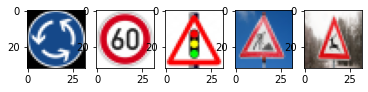

In [14]:
# Preview of inputs
f, axarr = plt.subplots(1,5)
for i in range(len(img_gallary)):
    axarr[i].imshow(img_gallary[i])
plt.show()

In [15]:
# Reset tf model
tf.reset_default_graph()

In [22]:
%%capture
# tf inputs
#Input image batch
x = tf.placeholder(tf.float32, (None, 32, 32, 3))

#Input label batch
y = tf.placeholder(tf.int32, (None))
rate = 0
#Encoding 
one_hot_y = tf.one_hot(y, 44)

#items will retrive from metadata
logits = LeNet(x)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

### Predict and anlyze the Sign Type

In [23]:

#Testing
with tf.Session() as sess:
    # Loading trained model
    saver.restore(sess, "./lenet")
    print("Load completed")

    #Check accuracy
    accuracy = sess.run(accuracy_operation, feed_dict={x: input4d, y: labels})
    eva_accuracy = evaluate(input4d,labels)
    print("Accuracy = {:.2f}".format(accuracy))
    
    #Show top 5 predicted probabilities
    predict = sess.run(logits, feed_dict={x: input4d, y: labels})
    prob = tf.nn.softmax(predict).eval()
    pre = sess.run(tf.nn.top_k(tf.constant(predict), k=5))

NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key Variable_24 not found in checkpoint
	 [[node save_2/RestoreV2 (defined at <ipython-input-22-4054b8e03f7b>:15) ]]

Original stack trace for 'save_2/RestoreV2':
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/asyncio/base_events.py", line 442, in run_forever
    self._run_once()
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/asyncio/base_events.py", line 1462, in _run_once
    handle._run()
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-489a5217d13b>", line 1, in <module>
    get_ipython().run_cell_magic('capture', '', '# tf inputs\n#Input image batch\nx = tf.placeholder(tf.float32, (None, 32, 32, 3))\n\n#Input label batch\ny = tf.placeholder(tf.int32, (None))\nrate = 0\n#Encoding \none_hot_y = tf.one_hot(y, 44)\n\n#items will retrive from metadata\nlogits = LeNet(x)\ncorrect_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))\naccuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))\nsaver = tf.train.Saver()\n')
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2371, in run_cell_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-63>", line 2, in capture
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1457, in capture
    self.shell.run_cell(cell)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-4054b8e03f7b>", line 15, in <module>
    saver = tf.train.Saver()
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 825, in __init__
    self.build()
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 837, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 875, in _build
    build_restore=build_restore)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 508, in _build_internal
    restore_sequentially, reshape)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 328, in _AddRestoreOps
    restore_sequentially)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 575, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1696, in restore_v2
    name=name)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/Users/clarence/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()
